# Car Insurance Claim Prediction Dataset

The Car Insurance Claim Prediction dataset contains:
- information on policyholders
    - having the attributes like policy tenure, age of the car, age of the car owner, the population density of the city, make and model of the car, power, engine type, etc,...
- and the target variable
    - indicating whether the policyholder files a claim in the next 6 months or not

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import kruskal, chi2_contingency

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

import shap
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

In [ ]:
from IPython.display import display
pd.options.display.max_columns = None

In [ ]:
train_df_pre = pd.read_csv('train.csv')
test_df_pre = pd.read_csv('test.csv')

In [ ]:
train_df_pre.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


# Data Preprocessing

The **bin2num()** function, takes in a categorical variable that is expected to contain binary responses represented as strings 'yes' or 'no' and systematically transforms these string values into numerical values, where 'yes' corresponds to 1 and 'no' corresponds to 0.

In [ ]:
def bin2num(var):
    train_df_pre[var] = train_df_pre[var].map({"No": 0, "Yes": 1})
    test_df_pre[var] = test_df_pre[var].map({"No": 0, "Yes": 1})

Iterate bin2num() through all yes/no variables to make them numerical.

In [ ]:
binary_features = [
    "is_esc",
    "is_adjustable_steering",
    "is_tpms",
    "is_parking_sensors",
    "is_parking_camera",
    "is_front_fog_lights",
    "is_rear_window_wiper",
    "is_rear_window_washer",
    "is_rear_window_defogger",
    "is_brake_assist",
    "is_power_door_locks",
    "is_central_locking",
    "is_power_steering",
    "is_driver_seat_height_adjustable",
    "is_day_night_rear_view_mirror",
    "is_ecw",
    "is_speed_alert"
]

for feature in binary_features:
    bin2num(feature)

In [ ]:
train_df_pre.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,1,1,0,1,1,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,1,0,0,1,1,1,1,1,1,1,1,1,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,0,0,0,0,1,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,0,0,0,0,0,1,1,1,0,1,1,1,2,0


# $\chi^2$ test

In [ ]:
categorical_vars = [
    "area_cluster",
    "make",
    "segment",
    "model",
    "fuel_type",
    "engine_type",
    "airbags",
    "is_esc",
    "is_adjustable_steering",
    "is_tpms",
    "is_parking_sensors",
    "is_parking_camera",
    "rear_brakes_type",
    "cylinder",
    "transmission_type",
    "gear_box",
    "steering_type",
    "is_front_fog_lights",
    "is_rear_window_wiper",
    "is_rear_window_washer",
    "is_rear_window_defogger",
    "is_brake_assist",
    "is_power_door_locks",
    "is_central_locking",
    "is_power_steering",
    "is_driver_seat_height_adjustable",
    "is_day_night_rear_view_mirror",
    "is_ecw",
    "is_speed_alert",
    "ncap_rating"
]

In [ ]:
chi2_pvalues = []
for var in categorical_vars:
    contingency_table = pd.crosstab(train_df_pre[var], train_df_pre['is_claim'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_pvalues.append((var, p))
chi2_pvalues.sort(key=lambda x: x[1])

In [ ]:
print("Test Chi-square p-values:")
for var, p in chi2_pvalues:
    print(f"- {var}: {p:.4f}")

Test Chi-square p-values:
- area_cluster: 0.0000
- is_adjustable_steering: 0.0008
- cylinder: 0.0012
- is_front_fog_lights: 0.0044
- is_brake_assist: 0.0088
- is_driver_seat_height_adjustable: 0.0102
- segment: 0.0274
- model: 0.0295
- engine_type: 0.0295
- is_parking_sensors: 0.0460
- is_day_night_rear_view_mirror: 0.0553
- fuel_type: 0.0561
- steering_type: 0.0568
- is_speed_alert: 0.0967
- is_power_door_locks: 0.1123
- is_central_locking: 0.1123
- is_ecw: 0.1123
- make: 0.3517
- is_esc: 0.4797
- is_rear_window_wiper: 0.5333
- is_rear_window_washer: 0.5333
- is_rear_window_defogger: 0.5427
- is_power_steering: 0.6486
- airbags: 0.7330
- ncap_rating: 0.8325
- is_parking_camera: 0.8465
- is_tpms: 0.8805
- rear_brakes_type: 0.8805
- transmission_type: 0.8914
- gear_box: 0.8932


According to the $\chi^2$ test results, the **most significant variables for predicting "is_claim"** appear to be:

- area_cluster
- is_adjustable_steering
- cylinder
- is_front_fog_lights
- is_brake_assist
- is_driver_seat_height_adjustable
- max_torque
- max_power
- segment
- model
- engine_type
- is_parking_sensors
- is_day_night_rear_view_mirror
- fuel_type
- steering_type
- is_speed_alert


On the other hand, variables:


- is_power_door_locks
- is_central_locking
- is_ecw
- make
- is_esc
- is_rear_window_wiper
- is_rear_window_washer
- is_rear_window_defogger
- is_power_steering
- airbags
- ncap_rating
- is_parking_camera
- is_tpms
- rear_brakes_type
- transmission_type
- gear_box

have higher p-values, suggesting they may have less influence on the target variable.

# PCA

In [ ]:
numerical_vars = [
    "policy_tenure",
    "age_of_car",
    "age_of_policyholder",
    "population_density",
    # "max_torque",
    # "max_power",
    "displacement",
    "turning_radius",
    "length",
    "width",
    "height",
    "gross_weight"
]

In [ ]:
numerical_data = train_df_pre[numerical_vars]
scaler = StandardScaler()
numerical_data_standardized = scaler.fit_transform(numerical_data)

In [ ]:
pca = PCA()
pca.fit(numerical_data_standardized)
components_df = pd.DataFrame(pca.components_, columns=numerical_vars)
explained_variance_ratio = pca.explained_variance_ratio_

In [ ]:
for i in range(len(components_df)):
    print(f"Component {i+1}")
    print(f"Explained Variance Ratio: {explained_variance_ratio[i]:.4f}")
    print("Loading Scores:")
    print(components_df.iloc[i].abs().sort_values(ascending=False))
    print("\n")

Component 1
Explained Variance Ratio: 0.5074
Loading Scores:
length                 0.435129
displacement           0.421910
turning_radius         0.409370
width                  0.402134
gross_weight           0.399924
height                 0.290308
age_of_car             0.209497
policy_tenure          0.110178
population_density     0.054969
age_of_policyholder    0.009573
Name: 0, dtype: float64


Component 2
Explained Variance Ratio: 0.1151
Loading Scores:
policy_tenure          0.667182
age_of_policyholder    0.648638
population_density     0.302775
height                 0.123809
age_of_car             0.117204
gross_weight           0.091644
turning_radius         0.046088
length                 0.037501
displacement           0.027328
width                  0.026884
Name: 1, dtype: float64


Component 3
Explained Variance Ratio: 0.1004
Loading Scores:
population_density     0.835321
age_of_policyholder    0.504129
age_of_car             0.173158
turning_radius         0.0683

The first 6 components explain the following percentage of the total variance:

-   Component 1: 50.74% (acc. 50.74%)
-   Component 2: 11.51% (acc. 62.25%)
-   Component 3: 10.04% (acc. 72.29%)
-   Component 4: 8.79% (acc. 81.08%)
-   Component 5: 7.67% (acc. 88.75%)
-   Component 6: 7.30% (acc. 96.05%)
The sum of these percentages is approximately 96.05%.

Principal variables are:

-   length
-   policy_tenure
-   population_density
-   height
-   age_of_car
-   age_of_policyholder
-   displacement
-   width
-   turning_radius

# Analysis of Variance (ANOVA)

## Numerical Features

In [ ]:
continuous_vars = train_df_pre.select_dtypes(include=['float64', 'int64']).columns.tolist()
continuous_pvalues = {}

for var in continuous_vars:
    model = ols('{} ~ C(is_claim)'.format(var), data=train_df_pre).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("ANOVA for variable:", var)
    print(anova_table)
    print("\n")
    p_value = anova_table.loc['C(is_claim)', 'PR(>F)']
    continuous_pvalues[var] = p_value

ANOVA for variable: policy_tenure
                  sum_sq       df           F        PR(>F)
C(is_claim)    62.320771      1.0  365.593096  3.018116e-81
Residual     9987.535419  58590.0         NaN           NaN


ANOVA for variable: age_of_car
                 sum_sq       df          F        PR(>F)
C(is_claim)    0.149607      1.0  46.537984  9.072911e-12
Residual     188.351229  58590.0        NaN           NaN


ANOVA for variable: age_of_policyholder
                 sum_sq       df          F        PR(>F)
C(is_claim)    0.445348      1.0  29.505774  5.597168e-08
Residual     884.333865  58590.0        NaN           NaN


ANOVA for variable: population_density
                   sum_sq       df          F    PR(>F)
C(is_claim)  5.795189e+09      1.0  18.586944  0.000016
Residual     1.826767e+13  58590.0        NaN       NaN


ANOVA for variable: make
                   sum_sq       df         F    PR(>F)
C(is_claim)      0.015736      1.0  0.012172  0.912149
Residual     7574

In [ ]:
print("Continuous Variables ANOVA p-values:")
for var, p_value in sorted(continuous_pvalues.items(), key=lambda x: x[1]):
    print(f"{var}: {p_value:.4f}")

Continuous Variables ANOVA p-values:
is_claim: 0.0000
policy_tenure: 0.0000
age_of_car: 0.0000
age_of_policyholder: 0.0000
population_density: 0.0000
is_adjustable_steering: 0.0008
cylinder: 0.0011
is_front_fog_lights: 0.0042
is_brake_assist: 0.0084
is_driver_seat_height_adjustable: 0.0097
width: 0.0161
is_parking_sensors: 0.0416
is_day_night_rear_view_mirror: 0.0531
displacement: 0.0631
is_speed_alert: 0.0769
is_power_door_locks: 0.1081
is_central_locking: 0.1081
is_ecw: 0.1081
length: 0.1159
gross_weight: 0.3459
ncap_rating: 0.3577
is_esc: 0.4685
airbags: 0.4997
turning_radius: 0.5096
is_rear_window_wiper: 0.5211
is_rear_window_washer: 0.5211
is_rear_window_defogger: 0.5310
is_power_steering: 0.6065
height: 0.6243
is_parking_camera: 0.8330
is_tpms: 0.8649
gear_box: 0.8778
make: 0.9121


**Interpretation of results:**

- ANOVA Table: The output you see after running the code provides a statistical test of whether the group means of the continuous variable are equal across the different levels of the categorical variable (is_claim). If is_claim has only two levels, this is essentially a **t-test**.
- PR(>F) (p-value): This column indicates the probability of observing the calculated F-statistic or a more extreme value given that the null hypothesis is true (in this case, the null hypothesis is that there are no differences between the group means). A p-value less than a chosen significance threshold (commonly 0.05) would lead to the rejection of the null hypothesis, suggesting that there is a statistically significant effect of is_claim on the continuous variable.

## Categorical Features

In [ ]:
categorical_vars = train_df_pre.select_dtypes(include=['object']).columns.tolist()
categorical_pvalues = {}

for var in categorical_vars:
    groups = []
    for group_name, group_data in train_df_pre.groupby('is_claim'):
        groups.append(group_data[var])
    print("Kruskal-Wallis H test for variable:", var)
    print(kruskal(*groups))
    print("\n")
    h_value, p_value = kruskal(*groups)
    categorical_pvalues[var] = p_value

Kruskal-Wallis H test for variable: policy_id
KruskalResult(statistic=np.float64(0.5133773524721619), pvalue=np.float64(0.47368046966695965))


Kruskal-Wallis H test for variable: area_cluster
KruskalResult(statistic=np.float64(2.592769741144916), pvalue=np.float64(0.1073524597258797))


Kruskal-Wallis H test for variable: segment
KruskalResult(statistic=np.float64(2.7183569189046066), pvalue=np.float64(0.0992000830763159))


Kruskal-Wallis H test for variable: model
KruskalResult(statistic=np.float64(2.612916963461148), pvalue=np.float64(0.1059966303582979))


Kruskal-Wallis H test for variable: fuel_type
KruskalResult(statistic=np.float64(5.40873484166179), pvalue=np.float64(0.02003623219310955))


Kruskal-Wallis H test for variable: max_torque
KruskalResult(statistic=np.float64(13.168011133910934), pvalue=np.float64(0.0002847688200337916))


Kruskal-Wallis H test for variable: max_power
KruskalResult(statistic=np.float64(3.236723797737833), pvalue=np.float64(0.07200449052981103))




In [ ]:
print("\nCategorical Variables Kruskal-Wallis H Test p-values:")
for var, p_value in sorted(categorical_pvalues.items(), key=lambda x: x[1]):
    print(f"{var}: {p_value:.4f}")


Categorical Variables Kruskal-Wallis H Test p-values:
max_torque: 0.0003
fuel_type: 0.0200
steering_type: 0.0208
max_power: 0.0720
segment: 0.0992
model: 0.1060
area_cluster: 0.1074
policy_id: 0.4737
engine_type: 0.8407
rear_brakes_type: 0.8649
transmission_type: 0.8774


**Interpretation of results:**

- The test statistic (H-statistic) is a measure of the degree to which the group medians differ. A higher value typically indicates greater differences between the group medians.
- The p-value tells you the probability of observing the computed statistic or one more extreme if the null hypothesis is true. In the context of the Kruskal-Wallis H test, the null hypothesis is that the population median of all groups is equal.

Following the above results, and taking $\alpha = 0.10$ (although 0.05 is a more common value), features to consider for the future model are:

**Numerical Features:**
- is_claim: 0.0000
- policy_tenure: 0.0000
- age_of_car: 0.0000
- age_of_policyholder: 0.0000
- population_density: 0.0000
- is_adjustable_steering: 0.0008
- cylinder: 0.0011
- is_front_fog_lights: 0.0042
- is_brake_assist: 0.0084
- is_driver_seat_height_adjustable: 0.0097
- width: 0.0161
- is_parking_sensors: 0.0416
- is_day_night_rear_view_mirror: 0.0531
- displacement: 0.0631
- is_speed_alert: 0.0769

**Categorical Features:**
- max_torque: 0.0003
- fuel_type: 0.0200
- steering_type: 0.0208
- max_power: 0.0720
- segment: 0.0992

In [ ]:
model_vars = [
    "is_claim",
    "policy_tenure",
    "age_of_car",
    "age_of_policyholder",
    "population_density",
    "is_adjustable_steering",
    "cylinder",
    "is_front_fog_lights",
    "is_brake_assist",
    "is_driver_seat_height_adjustable",
    "width",
    "is_parking_sensors",
    "is_day_night_rear_view_mirror",
    "displacement",
    "is_speed_alert",
    "max_torque",
    "fuel_type",
    "steering_type",
    "max_power",
    "segment"
]

In [ ]:
model_vars_test = model_vars.copy()
model_vars_test.remove("is_claim")
train_df = train_df_pre[model_vars].copy()
test_df = test_df_pre[model_vars_test].copy()

# EDA (and more Data Processing)

The **print_unique()** function takes in a categorical variable and prints a list of the unique values the variable takes.

In [ ]:
def print_unique(var):
    unique = train_df[var].unique()
    print(unique)
    return unique

The **count_occ()** function takes in a categorical variable and prints the amount of times each unique value of the variable appears.

In [ ]:
def count_occ(column_name, df=train_df):
    if column_name not in df.columns:
        raise ValueError("Column '{}' not found in the dataframe.".format(column_name))
    variable_counts = df[column_name].value_counts().to_dict()
    print(variable_counts)
    return variable_counts

The **applyOHE*()** function takes in a categorical variable and applies OneHot Encoding.

In [ ]:
def applyOHE(df, column):
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(df[[column]])
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out([column]))
    df = pd.concat([df.drop(columns=[column]), encoded_df], axis=1)
    return df

In [ ]:
train_df.head()

,is_claim,policy_tenure,age_of_car,age_of_policyholder,population_density,is_adjustable_steering,cylinder,is_front_fog_lights,is_brake_assist,is_driver_seat_height_adjustable,width,is_parking_sensors,is_day_night_rear_view_mirror,displacement,is_speed_alert,max_torque,fuel_type,steering_type,max_power,segment
0,0,0.515874,0.05,0.644231,4990,0,3,0,0,0,1515,1,0,796,1,60Nm@3500rpm,CNG,Power,40.36bhp@6000rpm,A
1,0,0.672619,0.02,0.375000,27003,0,3,0,0,0,1515,1,0,796,1,60Nm@3500rpm,CNG,Power,40.36bhp@6000rpm,A
2,0,0.841110,0.02,0.384615,4076,0,3,0,0,0,1515,1,0,796,1,60Nm@3500rpm,CNG,Power,40.36bhp@6000rpm,A
3,0,0.900277,0.11,0.432692,21622,1,4,1,1,1,1735,1,1,1197,1,113Nm@4400rpm,Petrol,Electric,88.50bhp@6000rpm,C1
4,0,0.596403,0.11,0.634615,34738,0,3,0,0,0,1579,0,1,999,1,91Nm@4250rpm,Petrol,Electric,67.06bhp@5500rpm,A


In [ ]:
train_df.describe()

,is_claim,policy_tenure,age_of_car,age_of_policyholder,population_density,is_adjustable_steering,cylinder,is_front_fog_lights,is_brake_assist,is_driver_seat_height_adjustable,width,is_parking_sensors,is_day_night_rear_view_mirror,displacement,is_speed_alert
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000
mean,0.063968,0.611246,0.069424,0.469420,18826.858667,0.606329,3.626963,0.579055,0.549171,0.585251,1672.233667,0.959500,0.380308,1162.355851,0.993805
std,0.244698,0.414156,0.056721,0.122886,17660.174792,0.488568,0.483616,0.493715,0.497581,0.492683,112.089135,0.197131,0.485467,266.304786,0.078467
min,0.000000,0.002735,0.000000,0.288462,290.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1475.000000,0.000000,0.000000,796.000000,0.000000
25%,0.000000,0.210250,0.020000,0.365385,6112.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1515.000000,1.000000,0.000000,796.000000,1.000000
50%,0.000000,0.573792,0.060000,0.451923,8794.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1735.000000,1.000000,0.000000,1197.000000,1.000000
75%,0.000000,1.039104,0.110000,0.548077,27003.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1755.000000,1.000000,1.000000,1493.000000,1.000000
max,1.000000,1.396641,1.000000,1.000000,73430.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1811.000000,1.000000,1.000000,1498.000000,1.000000


In [ ]:
train_df.isnull().sum()

,0
is_claim,0
policy_tenure,0
age_of_car,0
age_of_policyholder,0
population_density,0
is_adjustable_steering,0
cylinder,0
is_front_fog_lights,0
is_brake_assist,0
is_driver_seat_height_adjustable,0


No null values (NAs) on the dataset.

In [ ]:
train_df.duplicated().sum()

np.int64(0)

No duplicate rows on the dataset.

## policy_tenure

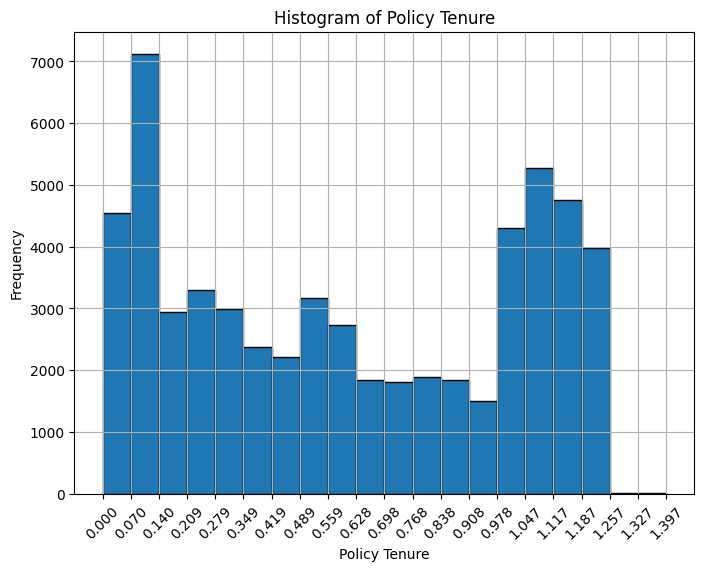

In [ ]:
max_value = train_df['policy_tenure'].max()
num_bins = int(np.ceil(max_value / 0.07))
bin_edges = np.linspace(0, max_value, num_bins + 1)

plt.figure(figsize=(8, 6))
plt.hist(train_df['policy_tenure'], bins=bin_edges, edgecolor='black')
plt.title('Histogram of Policy Tenure')
plt.xlabel('Policy Tenure')
plt.ylabel('Frequency')
plt.xticks(bin_edges)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
max_value = train_df['policy_tenure'].max()
min_value = train_df['policy_tenure'].min()
train_df['policy_tenure_normalized'] = (train_df['policy_tenure'] - min_value) / (max_value - min_value)
test_df['policy_tenure_normalized'] = (test_df['policy_tenure'] - min_value) / (max_value - min_value)

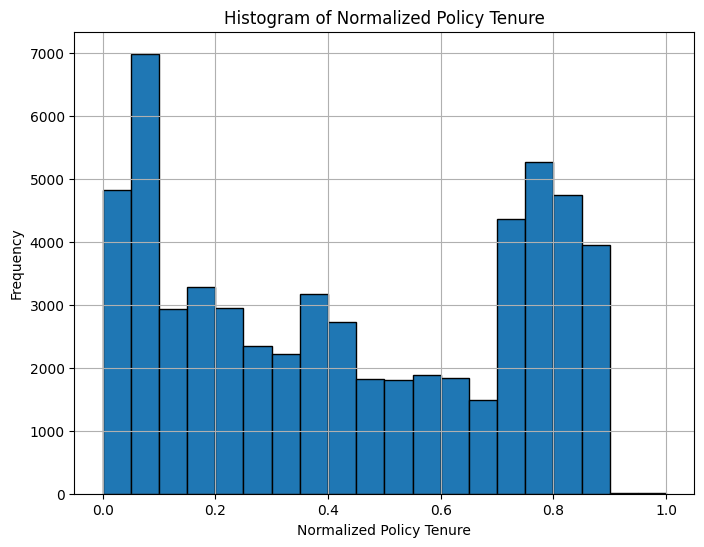

In [ ]:
num_bins = 20

plt.figure(figsize=(8, 6))
plt.hist(train_df['policy_tenure_normalized'], bins=num_bins, edgecolor='black')
plt.title('Histogram of Normalized Policy Tenure')
plt.xlabel('Normalized Policy Tenure')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## age_of_car

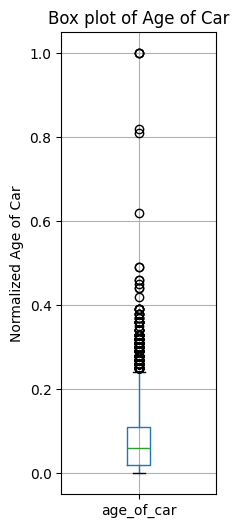

In [ ]:
plt.figure(figsize=(2, 6))
train_df.boxplot(column='age_of_car')
plt.title('Box plot of Age of Car')
plt.ylabel('Normalized Age of Car')
plt.show()

In [ ]:
outlier_threshold = 0.6
count_greater_th = (train_df['age_of_car'] > outlier_threshold).sum()
print(f"Number of normalized ages greater than {outlier_threshold}: {count_greater_th} ({round(100*count_greater_th/len(train_df), 2)}%)")

Number of normalized ages greater than 0.6: 6 (0.01%)


In [ ]:
train_df = train_df[train_df['age_of_car'] <= outlier_threshold].reset_index(drop=True)

In [ ]:
train_df['age_of_car'] = (train_df['age_of_car']) / outlier_threshold
test_df['age_of_car'] = (test_df['age_of_car']) / outlier_threshold

## age_of_policyholder

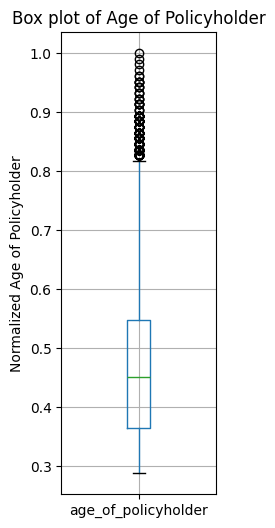

In [ ]:
plt.figure(figsize=(2, 6))
train_df.boxplot(column='age_of_policyholder')
plt.title('Box plot of Age of Policyholder')
plt.ylabel('Normalized Age of Policyholder')
plt.show()

## population_density

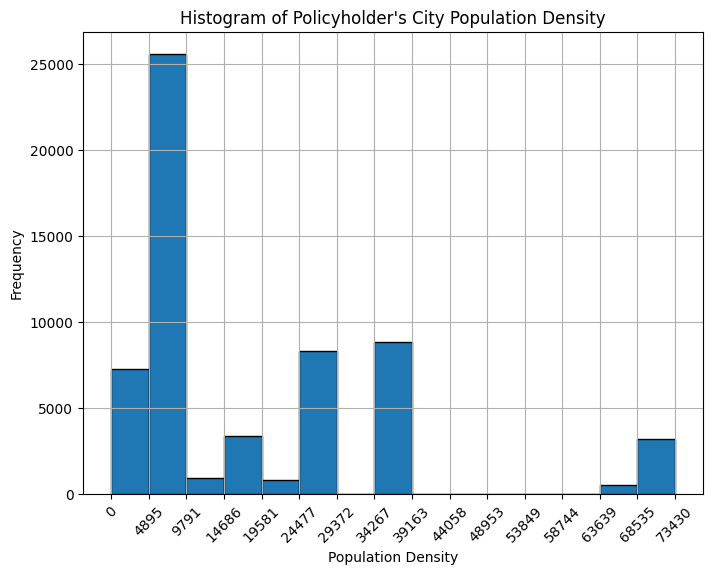

In [ ]:
max_value = train_df['population_density'].max()
num_bins = int(np.ceil(max_value / 5000))
bin_edges = np.linspace(0, max_value, num_bins + 1)

plt.figure(figsize=(8, 6))
plt.hist(train_df['population_density'], bins=bin_edges, edgecolor='black')
plt.title("Histogram of Policyholder's City Population Density")
plt.xlabel('Population Density')
plt.ylabel('Frequency')
plt.xticks(bin_edges)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
max_value = train_df['population_density'].max()
min_value = train_df['population_density'].min()
train_df['population_density'] = (train_df['population_density'] - min_value) / (max_value - min_value)
test_df['population_density'] = (test_df['population_density'] - min_value) / (max_value - min_value)

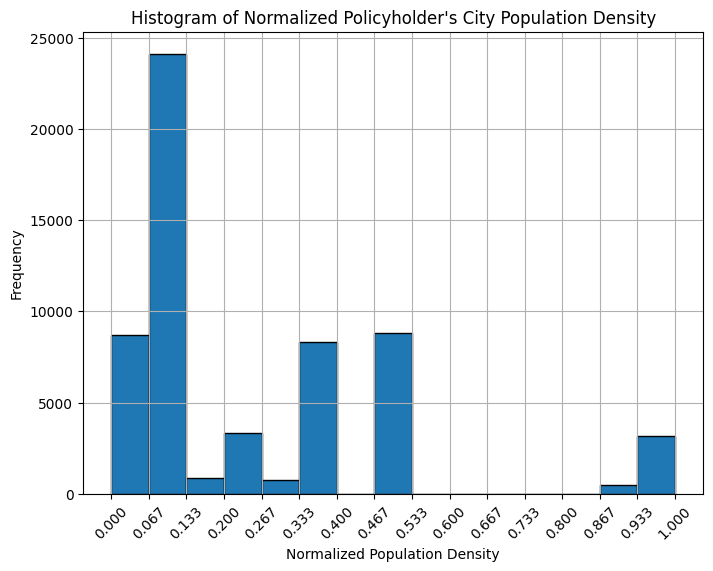

In [ ]:
num_bins = 15
bin_edges = np.linspace(0, 1, num_bins + 1)

plt.figure(figsize=(8, 6))
plt.hist(train_df['population_density'], bins=bin_edges, edgecolor='black')
plt.title("Histogram of Normalized Policyholder's City Population Density")
plt.xlabel('Normalized Population Density')
plt.ylabel('Frequency')
plt.xticks(bin_edges)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## segment

In [ ]:
print_unique("segment")

['A' 'C1' 'C2' 'B2' 'B1' 'Utility']


array(['A', 'C1', 'C2', 'B2', 'B1', 'Utility'], dtype=object)

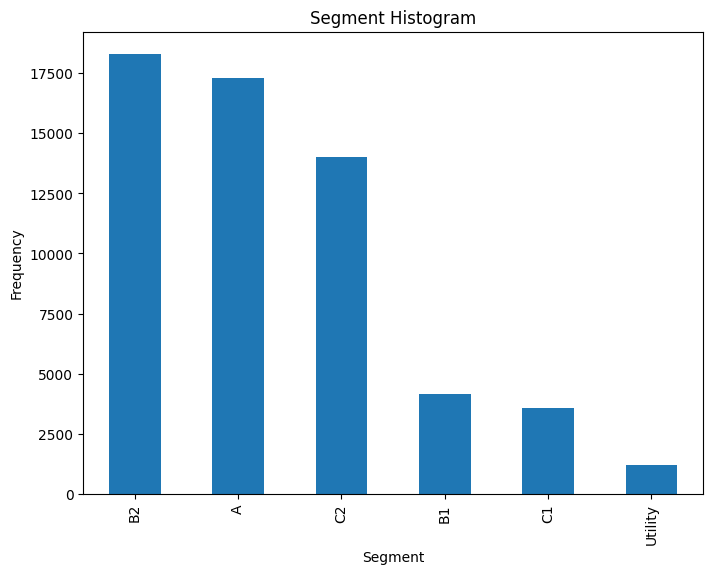

In [ ]:
plt.figure(figsize=(8, 6))
train_df['segment'].value_counts().plot(kind='bar')
plt.title('Segment Histogram')
plt.xlabel('Segment')
plt.ylabel('Frequency')
plt.show()

In [ ]:
train_df = applyOHE(train_df, 'segment')
test_df = applyOHE(test_df, 'segment')

## fuel_type

In [ ]:
print_unique("fuel_type")

['CNG' 'Petrol' 'Diesel']


array(['CNG', 'Petrol', 'Diesel'], dtype=object)

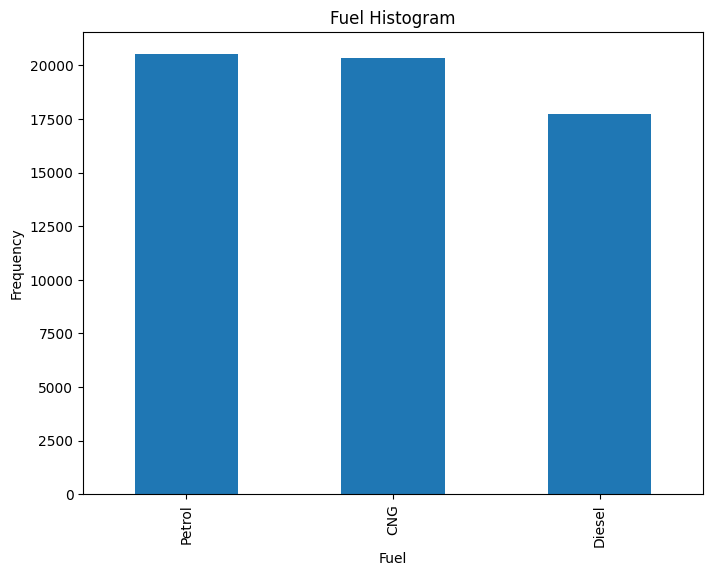

In [ ]:
plt.figure(figsize=(8, 6))
train_df['fuel_type'].value_counts().plot(kind='bar')
plt.title('Fuel Histogram')
plt.xlabel('Fuel')
plt.ylabel('Frequency')
plt.show()

In [ ]:
train_df = applyOHE(train_df, 'fuel_type')
test_df = applyOHE(test_df, 'fuel_type')

## max_torque

In [ ]:
print_unique("max_torque")

['60Nm@3500rpm' '113Nm@4400rpm' '91Nm@4250rpm' '250Nm@2750rpm'
 '200Nm@3000rpm' '82.1Nm@3400rpm' '200Nm@1750rpm' '85Nm@3000rpm'
 '170Nm@4000rpm']


array(['60Nm@3500rpm', '113Nm@4400rpm', '91Nm@4250rpm', '250Nm@2750rpm',
       '200Nm@3000rpm', '82.1Nm@3400rpm', '200Nm@1750rpm', '85Nm@3000rpm',
       '170Nm@4000rpm'], dtype=object)

In [ ]:
train_df[['max_torque_Nm', 'max_torque_rpm']] = train_df['max_torque'].str.split('@', expand=True)
train_df['max_torque_Nm'] = train_df['max_torque_Nm'].str.extract(r'(\d+\.?\d*)').astype(float)
train_df['max_torque_rpm'] = train_df['max_torque_rpm'].str.extract(r'(\d+)').astype(int)
train_df.drop(columns=['max_torque'], inplace=True)

In [ ]:
test_df[['max_torque_Nm', 'max_torque_rpm']] = test_df['max_torque'].str.split('@', expand=True)
test_df['max_torque_Nm'] = test_df['max_torque_Nm'].str.extract(r'(\d+\.?\d*)').astype(float)
test_df['max_torque_rpm'] = test_df['max_torque_rpm'].str.extract(r'(\d+)').astype(int)
test_df.drop(columns=['max_torque'], inplace=True)

## max_power

In [ ]:
print_unique("max_power")

['40.36bhp@6000rpm' '88.50bhp@6000rpm' '67.06bhp@5500rpm'
 '113.45bhp@4000rpm' '88.77bhp@4000rpm' '55.92bhp@5300rpm'
 '97.89bhp@3600rpm' '61.68bhp@6000rpm' '118.36bhp@5500rpm']


array(['40.36bhp@6000rpm', '88.50bhp@6000rpm', '67.06bhp@5500rpm',
       '113.45bhp@4000rpm', '88.77bhp@4000rpm', '55.92bhp@5300rpm',
       '97.89bhp@3600rpm', '61.68bhp@6000rpm', '118.36bhp@5500rpm'],
      dtype=object)

In [ ]:
train_df[['max_power_bhp', 'max_power_rpm']] = train_df['max_power'].str.split('@', expand=True)
train_df['max_power_bhp'] = train_df['max_power_bhp'].str.extract(r'(\d+\.?\d*)').astype(float)
train_df['max_power_rpm'] = train_df['max_power_rpm'].str.extract(r'(\d+)').astype(int)
train_df.drop(columns=['max_power'], inplace=True)

In [ ]:
test_df[['max_power_bhp', 'max_power_rpm']] = test_df['max_power'].str.split('@', expand=True)
test_df['max_power_bhp'] = test_df['max_power_bhp'].str.extract(r'(\d+\.?\d*)').astype(float)
test_df['max_power_rpm'] = test_df['max_power_rpm'].str.extract(r'(\d+)').astype(int)
test_df.drop(columns=['max_power'], inplace=True)

## steering_type

In [ ]:
print_unique("steering_type")

['Power' 'Electric' 'Manual']


array(['Power', 'Electric', 'Manual'], dtype=object)

In [ ]:
count_occ("steering_type")

{'Power': 33502, 'Electric': 23881, 'Manual': 1209}


{'Power': 33502, 'Electric': 23881, 'Manual': 1209}

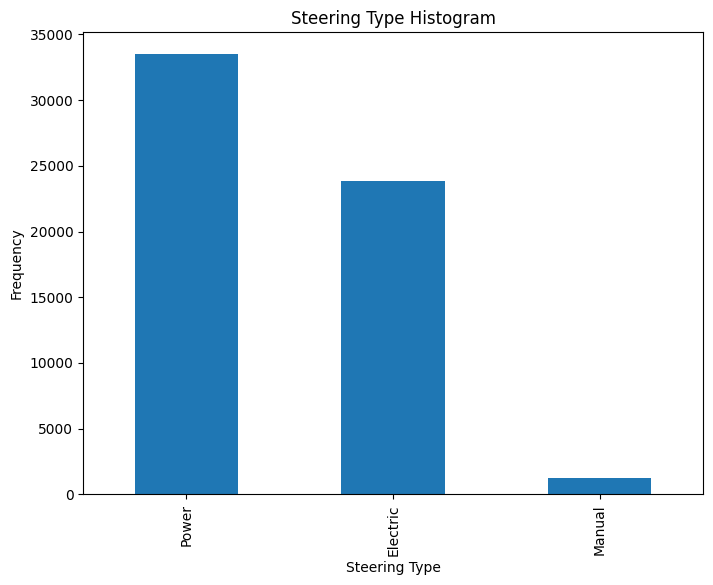

In [ ]:
plt.figure(figsize=(8, 6))
train_df['steering_type'].value_counts().plot(kind='bar')
plt.title('Steering Type Histogram')
plt.xlabel('Steering Type')
plt.ylabel('Frequency')
plt.show()

In [ ]:
train_df = applyOHE(train_df, 'steering_type')
test_df = applyOHE(test_df, 'steering_type')

## cylinder

In [ ]:
print_unique("cylinder")

[3 4]


array([3, 4])

In [ ]:
count_occ("cylinder")

{4: 36735, 3: 21857}


{4: 36735, 3: 21857}

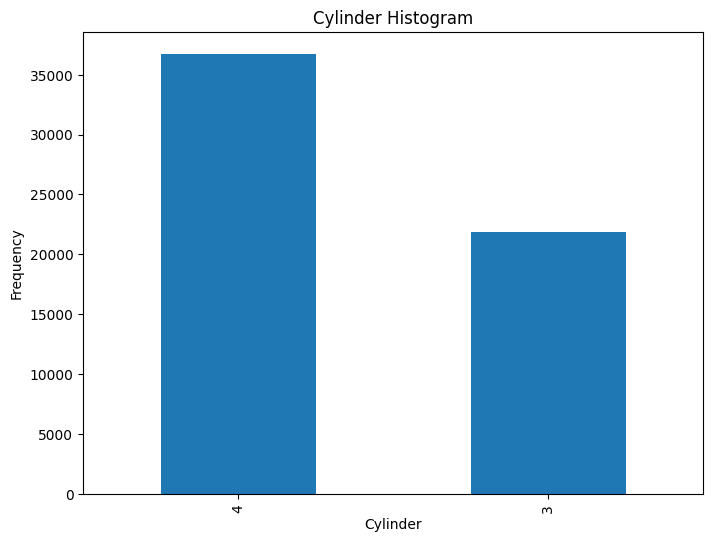

In [ ]:
plt.figure(figsize=(8, 6))
train_df['cylinder'].value_counts().plot(kind='bar')
plt.title('Cylinder Histogram')
plt.xlabel('Cylinder')
plt.ylabel('Frequency')
plt.show()

## width

In [ ]:
print_unique("width")

[1515 1735 1579 1790 1755 1745 1620 1695 1475 1811]


array([1515, 1735, 1579, 1790, 1755, 1745, 1620, 1695, 1475, 1811])

In [ ]:
count_occ("width")

{1515: 14948, 1735: 14856, 1790: 14018, 1620: 4173, 1745: 2940, 1579: 2373, 1695: 2114, 1755: 1598, 1475: 1209, 1811: 363}


{1515: 14948,
 1735: 14856,
 1790: 14018,
 1620: 4173,
 1745: 2940,
 1579: 2373,
 1695: 2114,
 1755: 1598,
 1475: 1209,
 1811: 363}

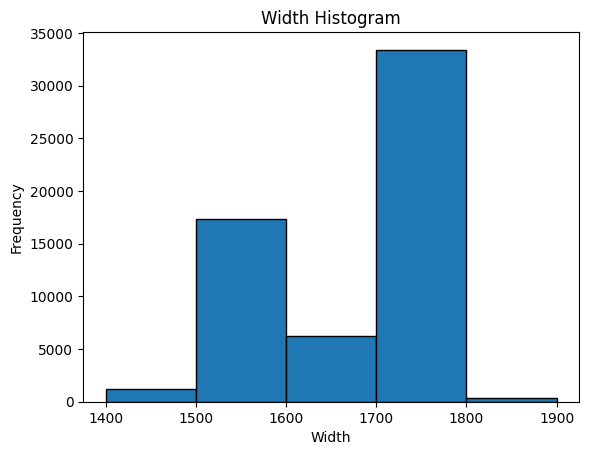

In [ ]:
bin_edges = np.arange(1400, 1901, 100)

plt.hist(train_df['width'], bins=bin_edges, edgecolor='black')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Width Histogram')
plt.show()

## displacement

In [ ]:
print_unique("displacement")

[ 796 1197  999 1493 1497  998 1498 1196 1199]


array([ 796, 1197,  999, 1493, 1497,  998, 1498, 1196, 1199])

In [ ]:
count_occ("displacement")

{1197: 17796, 796: 14948, 1493: 14018, 998: 4173, 999: 2373, 1498: 2114, 1497: 1598, 1196: 1209, 1199: 363}


{1197: 17796,
 796: 14948,
 1493: 14018,
 998: 4173,
 999: 2373,
 1498: 2114,
 1497: 1598,
 1196: 1209,
 1199: 363}

In [ ]:
train_df['displacement'].min()

796

In [ ]:
train_df['displacement'].max()

1498

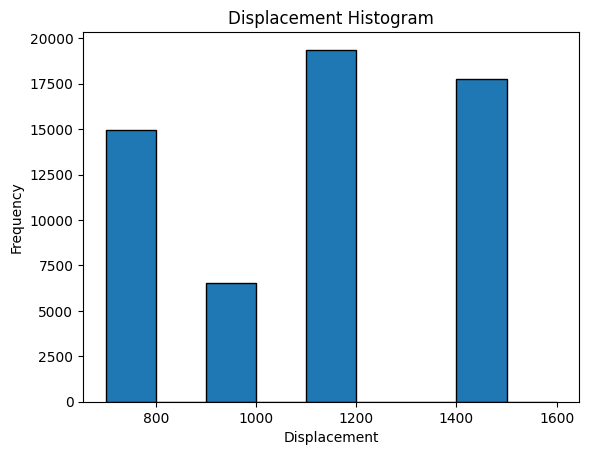

In [ ]:
bin_edges = np.arange(700, 1601, 100)  # Starting from 700 up to (but not including) 1601, with step size of 100

plt.hist(train_df['displacement'], bins=bin_edges, edgecolor='black')
plt.xlabel('Displacement')
plt.ylabel('Frequency')
plt.title('Displacement Histogram')
plt.show()

## binary variables (is_adjustable_steering, is_front_fog_lights, is_brake_assist, is_driver_seat_height_adjustable, is_parking_sensors, is_day_night_rear_view_mirror, is_speed_alert)

In [ ]:
binary_model_vars = ["is_adjustable_steering",
                     "is_front_fog_lights",
                     "is_brake_assist",
                     "is_driver_seat_height_adjustable",
                     "is_parking_sensors",
                     "is_day_night_rear_view_mirror",
                     "is_speed_alert"
]

for bin_feature in binary_model_vars:
    print(f"Variable {bin_feature}")
    print_unique(bin_feature)
    count_occ(bin_feature)
    print(f"\n")

Variable is_adjustable_steering
[0 1]
{1: 35526, 0: 23066}


Variable is_front_fog_lights
[0 1]
{1: 33928, 0: 24664}


Variable is_brake_assist
[0 1]
{1: 32177, 0: 26415}


Variable is_driver_seat_height_adjustable
[0 1]
{1: 34291, 0: 24301}


Variable is_parking_sensors
[1 0]
{1: 56219, 0: 2373}


Variable is_day_night_rear_view_mirror
[0 1]
{0: 36309, 1: 22283}


Variable is_speed_alert
[1 0]
{1: 58229, 0: 363}




## is_claim (target variable)

In [ ]:
print(f"The ratio of positive (1) to negative (0) values is 1:{round((len(train_df.is_claim) - sum(train_df.is_claim)) / sum(train_df.is_claim), 1)}")

The ratio of positive (1) to negative (0) values is 1:14.6


Summary of processing applied to kept variables:
- **policy_tenure:** normalize
- **age_of_car:** remove outliers and normalize
- **age_of_policyholder:** nothing
- **population_density:** normalize
- **is_adjustable_steering:** converted from yes/no to 1/0
- **cylinder:** nothing
- **is_front_fog_lights:** converted from yes/no to 1/0
- **is_brake_assist:** converted from yes/no to 1/0
- **is_driver_seat_height_adjustable:** converted from yes/no to 1/0
- **width:** nothing
- **is_parking_sensors:** converted from yes/no to 1/0
- **is_day_night_rear_view_mirror:** converted from yes/no to 1/0
- **displacement:** nothing
- **is_speed_alert:** converted from yes/no to 1/0
- **max_torque:** considered Nm and rpm in two different columns
- **fuel_type:** OneHotEncoding
- **steering_type:** OneHotEncoding
- **max_power:** considered bhp and rpm in two different columns
- **segment:** OneHotEncoding

# Analysis of Correlations

In [ ]:
correlation_matrix = train_df.corr()

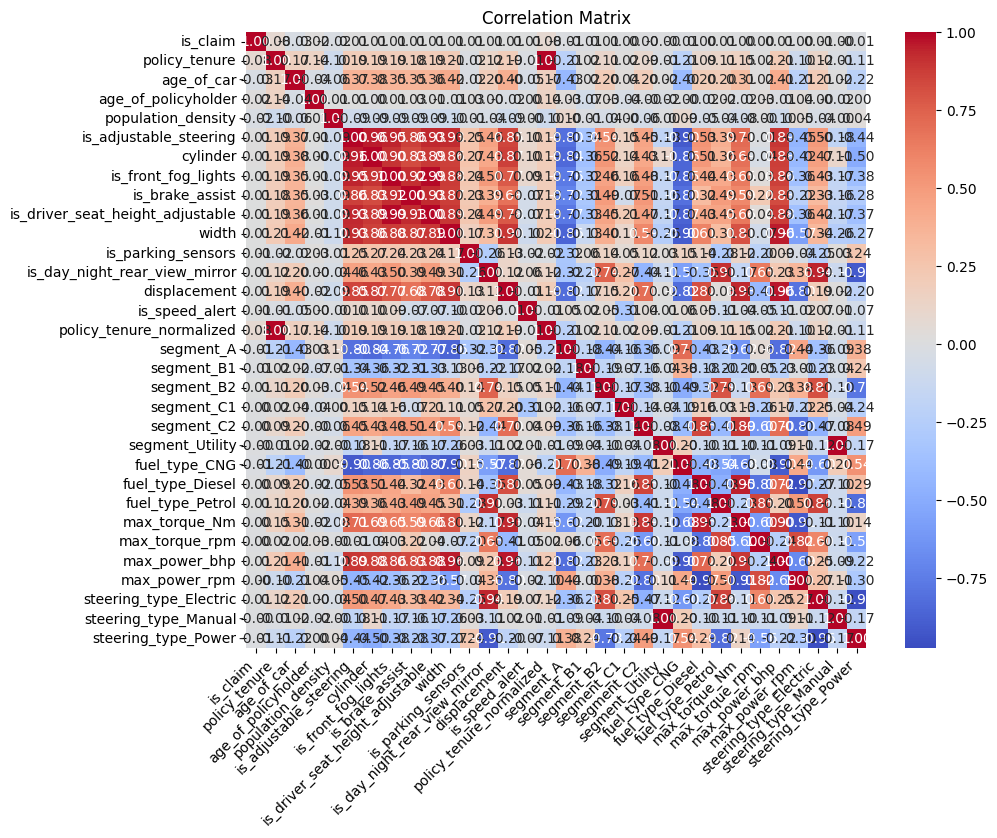

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
correlation_series = upper_triangle.stack()
sorted_correlations = correlation_series.abs().sort_values(ascending=False)
print(sorted_correlations)

segment_Utility      steering_type_Manual                1.000000
policy_tenure        policy_tenure_normalized            1.000000
is_front_fog_lights  is_driver_seat_height_adjustable    0.987345
fuel_type_Diesel     max_power_rpm                       0.973494
displacement         max_power_bhp                       0.962629
                                                           ...   
population_density   max_torque_rpm                      0.000753
is_claim             segment_C2                          0.000709
age_of_policyholder  fuel_type_CNG                       0.000322
is_claim             segment_C1                          0.000129
                     max_power_rpm                       0.000089
Length: 496, dtype: float64


# XGBoost Classifier

Design of an XGBoost Classifier.

## Data Preparation

In [ ]:
X = train_df.drop('is_claim', axis=1)
y = train_df['is_claim']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=33)

In [ ]:
print('Positive to all in train: ', round(sum(y_train) / len(y_train), 4))
print('Positive to all in validation: ', round(sum(y_val) / len(y_val), 4))

Positive to all in train:  0.0634
Positive to all in validation:  0.0663


In [ ]:
os.environ['LOKY_MAX_CPU_COUNT'] = '8'  # Set the desired number of CPU cores
balance_ratio = 0.3/(1-(sum(y_train) / len(y_train)))
smote = SMOTE()
# smote = SMOTE(sampling_strategy = balance_ratio)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print('Positive to all in train: ', round(sum(y_train_resampled) / len(y_train_resampled), 4))

Positive to all in train:  0.5


## Model Definition

In [ ]:
model_xgb = XGBClassifier(use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=33,
                          # tree_method='gpu_hist',
                          device='cpu')

## Hyperparameter tuning

In [ ]:
imbalance_ratio = (1 - sum(y_train_resampled) / len(y_train_resampled)) / (sum(y_train_resampled) / len(y_train_resampled))
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.2, 0.4],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'scale_pos_weight': [1, imbalance_ratio, 2*imbalance_ratio]
}

In [ ]:
# Smaller grid to allow the code to run completely on Kaggle
param_grid = {
    'n_estimators': [1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5],
    'scale_pos_weight': [2]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    # verbose=3,
    n_jobs=-1
)

start = time.time()
grid_search.fit(X_train_resampled, y_train_resampled)
end = time.time()

print("Time spent tunning (in hours):", round((end-start)/3600, 2))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:27:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Time spent tunning (in hours): 0.42


In [ ]:
print("Best score: %.2f" % grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Best score: 0.98
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'scale_pos_weight': 2, 'subsample': 0.5}


In [ ]:
best_model_xgb = grid_search.best_estimator_

In [ ]:
preds = best_model_xgb.predict(X_val)
y_val = y_val.astype(int)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10941
           1       0.10      0.05      0.07       777

    accuracy                           0.91     11718
   macro avg       0.52      0.51      0.51     11718
weighted avg       0.88      0.91      0.89     11718



# XGBoost Classifier Metric Results

The parameter grid used for hyperparameter tunnig of the XGBoost Classifier is

```py
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.2, 0.4],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'scale_pos_weight': [1, imbalance_ratio, 2*imbalance_ratio]
}
```

## No Class Balancing

**Best AUC-ROC:** 0.66

**Parameters:** {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 1000, 'scale_pos_weight': 1, 'subsample': 1.0}

**Time:** 1.85 hours

|               |   precision   |    recall     |   f1-score    |    support    |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
|       0       |     0.93      |     1.00      |     0.97      |     10941     |
|       1       |     0.00      |     0.00      |     0.00      |      777      |
|               |               |               |               |               |
|   accuracy    |               |               |     0.93      |     11718     |
|  macro avg    |     0.47      |     0.50      |     0.48      |     11718     |
| weighted avg  |     0.87      |     0.93      |     0.90      |     11718     |

## 50/50 Class Balancing (SMOTE())

**Best AUC-ROC:** 0.98

**Parameters:** {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'scale_pos_weight': 2.0, 'subsample': 0.5}

**Time:** 4.94 hours

|               |   precision   |    recall     |   f1-score    |    support    |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
|       0       |     0.93      |     0.96      |     0.95      |     10941     |
|       1       |     0.10      |     0.06      |     0.07      |      777      |
|               |               |               |               |               |
|   accuracy    |               |               |     0.90      |     11718     |
|  macro avg    |     0.52      |     0.51      |     0.51      |     11718     |
| weighted avg  |     0.88      |     0.90      |     0.89      |     11718     |

## $\approx$ 24/76 Class Balancing (SMOTE(sampling_strategy = 0.32))

**Best AUC-ROC:** 0.94

**Parameters:** {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'scale_pos_weight': 6.2442389758179235, 'subsample': 0.5}

**Time:** 3.46 hours

|               |   precision   |    recall     |   f1-score    |    support    |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
|       0       |     0.94      |     0.91      |     0.92      |     10941     |
|       1       |     0.09      |     0.12      |     0.10      |      777      |
|               |               |               |               |               |
|   accuracy    |               |               |     0.86      |     11718     |
|  macro avg    |     0.51      |     0.52      |     0.51      |     11718     |
| weighted avg  |     0.88      |     0.86      |     0.87      |     11718     |

# SHAP Values

In [ ]:
explainer = shap.Explainer(best_model_xgb)

In [ ]:
shap_values = explainer.shap_values(X_train_resampled)

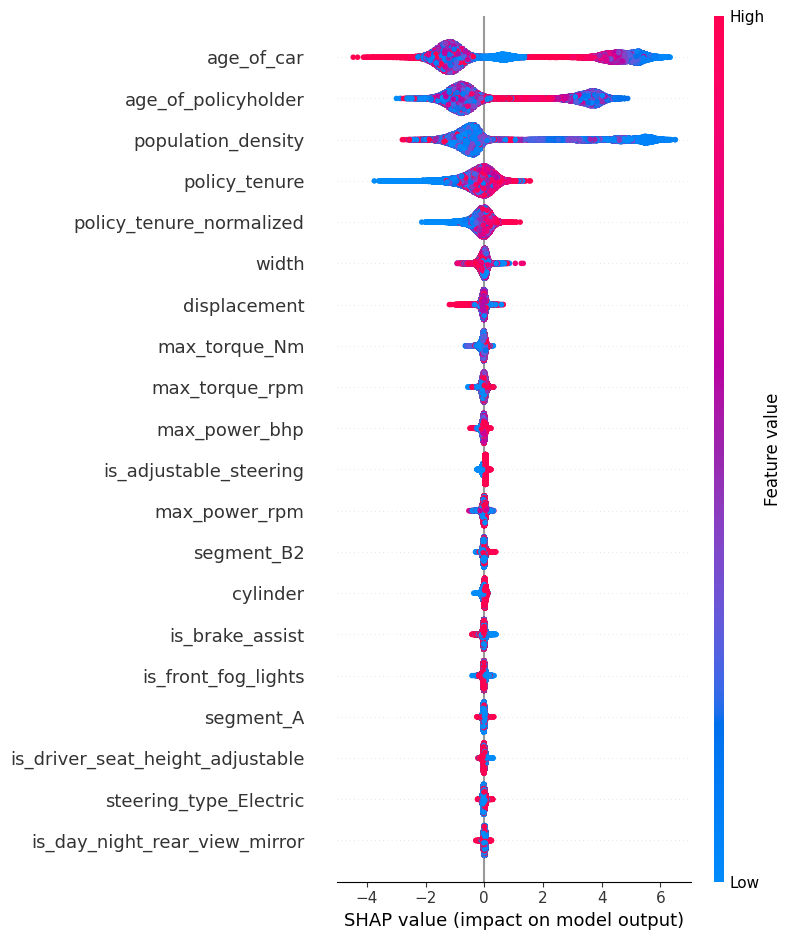

In [ ]:
shap.summary_plot(shap_values, X_train_resampled)

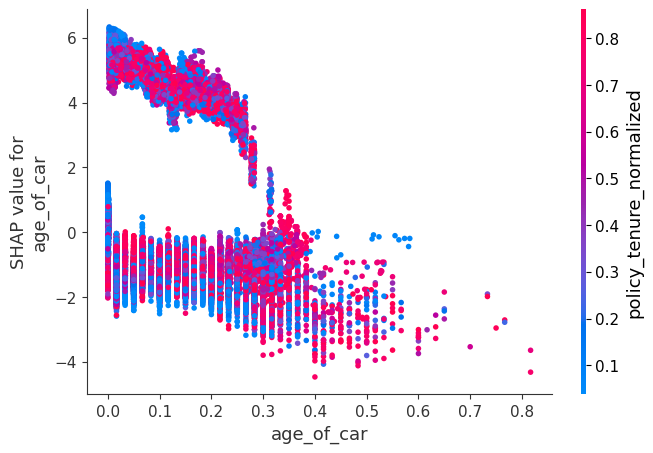

In [ ]:
shap.dependence_plot("age_of_car", shap_values, X_train_resampled, interaction_index="policy_tenure_normalized")

# Submission (XGBoost Predictions)

In [ ]:
predictions = best_model_xgb.predict(test_df)
policy_ids = test_df_pre["policy_id"]
submission_df = pd.DataFrame({'policy_id': policy_ids, 'prediction': predictions})
submission_df.to_csv('submission.csv', index=False)

In [ ]:
submission_df.shape

(39063, 2)

In [ ]:
submission_df

,policy_id,prediction
0,ID58593,0
1,ID58594,0
2,ID58595,0
3,ID58596,0
4,ID58597,0
...,...,...
39058,ID97651,0
39059,ID97652,0
39060,ID97653,0
39061,ID97654,0


# Random Forest

How well would a Random Forest Classifier perform compared to XGBoost?

In [97]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [98]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [92]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='roc_auc')

In [93]:
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [94]:
best_rf_model = grid_search.best_estimator_

In [95]:
preds_rf = best_rf_model.predict(X_val)
y_val = y_val.astype(int)
print(classification_report(y_val, preds_rf))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10941
           1       0.09      0.09      0.09       777

    accuracy                           0.88     11718
   macro avg       0.51      0.51      0.51     11718
weighted avg       0.88      0.88      0.88     11718



In [96]:
# Re-running data preparation steps
model_vars = [
    "is_claim",
    "policy_tenure",
    "age_of_car",
    "age_of_policyholder",
    "population_density",
    "is_adjustable_steering",
    "cylinder",
    "is_front_fog_lights",
    "is_brake_assist",
    "is_driver_seat_height_adjustable",
    "width",
    "is_parking_sensors",
    "is_day_night_rear_view_mirror",
    "displacement",
    "is_speed_alert",
    "max_torque",
    "fuel_type",
    "steering_type",
    "max_power",
    "segment"
]

model_vars_test = model_vars.copy()
model_vars_test.remove("is_claim")
train_df = train_df_pre[model_vars].copy()
test_df = test_df_pre[model_vars_test].copy()

# Remove outliers from age_of_car
outlier_threshold = 0.6
train_df = train_df[train_df['age_of_car'] <= outlier_threshold].reset_index(drop=True)

# Normalize policy_tenure
max_value = train_df['policy_tenure'].max()
min_value = train_df['policy_tenure'].min()
train_df['policy_tenure_normalized'] = (train_df['policy_tenure'] - min_value) / (max_value - min_value)
test_df['policy_tenure_normalized'] = (test_df['policy_tenure'] - min_value) / (max_value - min_value)

# Normalize age_of_car
train_df['age_of_car'] = (train_df['age_of_car']) / outlier_threshold
test_df['age_of_car'] = (test_df['age_of_car']) / outlier_threshold

# Normalize population_density
max_value = train_df['population_density'].max()
min_value = train_df['population_density'].min()
train_df['population_density'] = (train_df['population_density'] - min_value) / (max_value - min_value)
test_df['population_density'] = (test_df['population_density'] - min_value) / (max_value - min_value)


# One-hot encode categorical features
train_df = applyOHE(train_df, 'segment')
test_df = applyOHE(test_df, 'segment')
train_df = applyOHE(train_df, 'fuel_type')
test_df = applyOHE(test_df, 'fuel_type')
train_df = applyOHE(train_df, 'steering_type')
test_df = applyOHE(test_df, 'steering_type')

# Process max_torque and max_power
train_df[['max_torque_Nm', 'max_torque_rpm']] = train_df['max_torque'].str.split('@', expand=True)
train_df['max_torque_Nm'] = train_df['max_torque_Nm'].str.extract(r'(\d+\.?\d*)').astype(float)
train_df['max_torque_rpm'] = train_df['max_torque_rpm'].str.extract(r'(\d+)').astype(int)
train_df.drop(columns=['max_torque'], inplace=True)

test_df[['max_torque_Nm', 'max_torque_rpm']] = test_df['max_torque'].str.split('@', expand=True)
test_df['max_torque_Nm'] = test_df['max_torque_Nm'].str.extract(r'(\d+\.?\d*)').astype(float)
test_df['max_torque_rpm'] = test_df['max_torque_rpm'].str.extract(r'(\d+)').astype(int)
test_df.drop(columns=['max_torque'], inplace=True)

train_df[['max_power_bhp', 'max_power_rpm']] = train_df['max_power'].str.split('@', expand=True)
train_df['max_power_bhp'] = train_df['max_power_bhp'].str.extract(r'(\d+\.?\d*)').astype(float)
train_df['max_power_rpm'] = train_df['max_power_rpm'].str.extract(r'(\d+)').astype(int)
train_df.drop(columns=['max_power'], inplace=True)

test_df[['max_power_bhp', 'max_power_rpm']] = test_df['max_power'].str.split('@', expand=True)
test_df['max_power_bhp'] = test_df['max_power_bhp'].str.extract(r'(\d+\.?\d*)').astype(float)
test_df['max_power_rpm'] = test_df['max_power_rpm'].str.extract(r'(\d+)').astype(int)
test_df.drop(columns=['max_power'], inplace=True)

X = train_df.drop('is_claim', axis=1)
y = train_df['is_claim']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=33)

# Apply SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)